In [1]:
import config
from RiotAPI import *
from RiotRequest import RiotRequest
from RiotUtil import convert_timestamp

import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# initialize
api_key = config.api_key
summoner_name = "한양대판팡학파"
account_id = get_account_id(summoner_name)

## Match Time History

In [3]:
history = [match['gameId'] for match in get_this_season_match_history(account_id)]

In [4]:
len(history)

334

In [5]:
# get game detail에서 gameCreation, gameDuration, win/lose data 불러오기
# 이걸 굳이 함수로 작성할 필요가 있나?
def get_timeinfo(accountId, MatchDto):
    return [MatchDto['gameCreation'], MatchDto['gameDuration'], win_match(account_id, MatchDto)]
 
def win_match(accountId, MatchDto):
    '''accountId가 matchId에서 이겼으면 True, 졌으면 False를 반환.내부에서 get_game_detail 리퀘스트를 보낸다 '''
    
    detail = MatchDto
    
    # get the participant Id of the user in the specific match
    for p in detail['participantIdentities']:
        if p['player']['accountId'] == accountId:
            participantId = p['participantId']
            break
            
    # team 100의 결과('Fail' or 'Win')
    team100 = detail['teams'][0]['win'] 
    
    # participant belongs to team 100
    if participantId <= 5:    
        return team100 == 'Win' 
    
    # participant belongs to team 200
    else:            
        return team100 == 'Fail'

In [6]:
# list of match id --> list of [matchId, creation, duration, win]
# ignore errors
time_history = []
for matchId in history:
    try:
        MatchDto = get_game_detail(matchId)
        time_history.append([matchId, MatchDto['gameCreation'], MatchDto['gameDuration'], win_match(account_id, MatchDto)])
    except:
        pass
        
match_df = pd.DataFrame(time_history, columns=['matchId', 'creation', 'duration', 'win'])

# add unix timestamp of the time game ended
match_df['ended'] = match_df['creation'] + match_df['duration']*1000

# add datetime columns for creation and ending time
match_df['creation_dt'] = match_df['creation'].apply(convert_timestamp)
match_df['ended_dt'] = match_df['ended'].apply(convert_timestamp)

match_df.head()

Unhandled Error 503 : https://kr.api.riotgames.com/lol/match/v4/matches/3676567045?api_key=RGAPI-5d4d9788-7f08-485b-86de-c8528dc9baac
Exceeded Rate Limiting. Will retry After 59 seconds
Exceeded Rate Limiting. Will retry After 74 seconds
Exceeded Rate Limiting. Will retry After 70 seconds


,matchId,creation,duration,win,ended,creation_dt,ended_dt
0,3679385560,1558928546016,1646,False,1558930192016,2019-05-27 12:42:26.016000+09:00,2019-05-27 13:09:52.016000+09:00
1,3679334911,1558926391375,1847,False,1558928238375,2019-05-27 12:06:31.375000+09:00,2019-05-27 12:37:18.375000+09:00
2,3677409689,1558805311205,2020,False,1558807331205,2019-05-26 02:28:31.205000+09:00,2019-05-26 03:02:11.205000+09:00
3,3677421884,1558802220068,1565,True,1558803785068,2019-05-26 01:37:00.068000+09:00,2019-05-26 02:03:05.068000+09:00
4,3676519145,1558771148765,1798,True,1558772946765,2019-05-25 16:59:08.765000+09:00,2019-05-25 17:29:06.765000+09:00


## Grouping Matches
__match_df: 개별 게임 기록을 하나의 row로 하는 dataframe__
- matchId(index)
- creation: __long__ 게임이 시작하는 unix timestamp
- duration: __int__ 게임 지속 시간 in seconds (*millisedconds가 아님에 유의*)
- ended: __long__ 게임이 끝나는 unix timestamp
- creation_dt: __datetime__ creation을 korean time으로 전환한 시각   
- ended_dt: __datetime__ ended를 korean time으로 전환한 시각  
- diff: __long__ 이번 판과 다음 판(시간 상으로 다음판, row 순서로는 바로 위 row)과의 시간 차이 in seconds

__seq_df: 연속 게임 기록을 하나의 row로 하는 dataframe__
- matchIds: list[matchId]
- matchNum: __int__ 연속으로 한 판 수
- start_dt: __datetime__ 연속 게임 기록의 시작시간
- end_dt: __datetime__ 연속 게임 기록의 끝나는 시간

### Calculate differences

In [7]:
# append diff
diff = np.array(match_df['creation'][:-1]) - np.array(match_df['ended'][1:])
full_diff = np.append([float('Inf')], diff)
match_df['diff'] = full_diff

In [8]:
match_df.set_index('matchId', inplace=True)
match_df.head()

,creation,duration,win,ended,creation_dt,ended_dt,diff
matchId,,,,,,,
3679385560,1558928546016,1646,False,1558930192016,2019-05-27 12:42:26.016000+09:00,2019-05-27 13:09:52.016000+09:00,inf
3679334911,1558926391375,1847,False,1558928238375,2019-05-27 12:06:31.375000+09:00,2019-05-27 12:37:18.375000+09:00,3.076410e+05
3677409689,1558805311205,2020,False,1558807331205,2019-05-26 02:28:31.205000+09:00,2019-05-26 03:02:11.205000+09:00,1.190602e+08
3677421884,1558802220068,1565,True,1558803785068,2019-05-26 01:37:00.068000+09:00,2019-05-26 02:03:05.068000+09:00,1.526137e+06
3676519145,1558771148765,1798,True,1558772946765,2019-05-25 16:59:08.765000+09:00,2019-05-25 17:29:06.765000+09:00,2.927330e+07


### Contruct Sequence Data

In [9]:
# contruct sequence data
seqs = []

for index, row in match_df.iterrows():
    if row['diff'] > 600000: # diff with previous game bigger than 10 minutes
        seqs.append([index]) # start a new sequence(nested list) in seqs
    else: # diff with previous game smaller than 10 minutes
        seqs[-1].append(index) # add the match to an existing sequence

In [10]:
seq_df = pd.DataFrame()

# list of ids of matches
seq_df['matchIds'] = seqs
# how many matches in a row
seq_df['matchNum'] = [len(seq) for seq in seqs]
# start_dt
seq_df['start_dt'] = [match_df.loc[seq[-1]]['creation_dt'] for seq in seqs]
# end_dt
seq_df['end_dt'] = [match_df.loc[seq[0]]['ended_dt'] for seq in seqs]

seq_df.head()

,matchIds,matchNum,start_dt,end_dt
0,"[3679385560, 3679334911]",2,2019-05-27 12:06:31.375000+09:00,2019-05-27 13:09:52.016000+09:00
1,[3677409689],1,2019-05-26 02:28:31.205000+09:00,2019-05-26 03:02:11.205000+09:00
2,[3677421884],1,2019-05-26 01:37:00.068000+09:00,2019-05-26 02:03:05.068000+09:00
3,[3676519145],1,2019-05-25 16:59:08.765000+09:00,2019-05-25 17:29:06.765000+09:00
4,[3674658576],1,2019-05-24 17:51:09.191000+09:00,2019-05-24 18:25:51.191000+09:00


## 데이터 저장하기
sqlite에서는 datetime object가 저장이 안돼서 pickle로

In [ ]:
import pickle

match_df.to_pickle("match.pickle")
seq_df.to_pickle("sequence.pickle")

with open('match.pickle', 'rb') as f:
    data = pickle.load(f)
data.head()

### Match Dataframe 에 seq_idx(몇번째 판인지) 추가
#### 참고: Dataframe의 Chained Assignment 
https://www.dataquest.io/blog/settingwithcopywarning/  
문제 - 계속 SettingWithCopyWarning 나옴. bracket을 두 개 이상 사용해서(chaining) 접근한 subset of data는 original data가 아니라 copy 된 것. 여기에 할당을 해봤자 원데이터는 바뀌지 않는다
해결책 - loc에 합친다  
Chaining Assignment: `data[data.bidder == 'parakeet2004']['bidderrate'] = 100`   
=> .loc을 활용한 single operation: `data.loc[data.bidder == 'parakeet2004', 'bidderrate'] = 100` 

In [11]:
# 몇 번째 판인지
match_df['seq_idx'] = np.nan
for seq in seq_df['matchIds']:
    for idx, match in enumerate(seq):
        match_df.loc[match, 'seq_idx'] = idx

In [ ]:
match_df.head()

In [12]:
grouped = match_df[['win', 'seq_idx']].groupby('seq_idx')
grouped_win = (grouped.sum()/grouped.count())['win'].values

In [ ]:
list(range(len(grouped))) # 이거 unique x 값으로 고쳐야

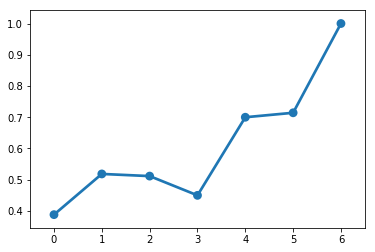

In [13]:
import seaborn as sns
%matplotlib inline

sns.pointplot(x=list(range(len(grouped))), y=grouped_win)

## Insights on Play Time

### 한 번에 켰을 때 몇 판이나 연속으로 했을까  
seaborn countplot

In [14]:
matchNum = seq_df['matchNum'].value_counts()
matchNum

1    89
2    38
3    23
4    10
6     5
5     3
7     2
Name: matchNum, dtype: int64

Text(0,0.5,'Count')

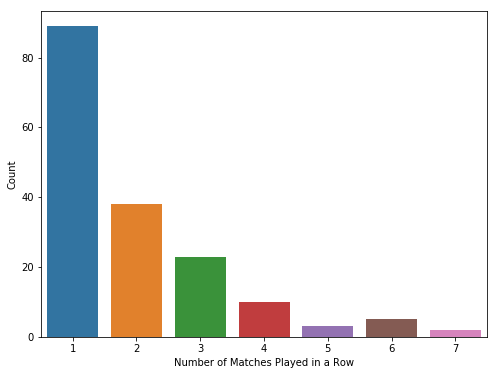

In [15]:
plt.figure(figsize=(8,6))
sns.countplot(x='matchNum', data=seq_df)
plt.xlabel('Number of Matches Played in a Row')
plt.ylabel('Count')

### 무슨 요일, 어떤 시간대에 게임을 할까  
seaborn heatmap: https://seaborn.pydata.org/generated/seaborn.heatmap.html

In [16]:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
match_df['weekday'] = [dt.weekday() for dt in match_df['creation_dt']]
match_df['hour'] = [dt.hour for dt in match_df['creation_dt']]
matchTime = match_df.groupby('weekday')['hour'].value_counts().unstack().fillna(0)
matchTime

hour,0,1,2,3,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
weekday,,,,,,,,,,,,,,,,,,,
0,10.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,3.0,4.0,9.0,5.0
1,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,4.0,6.0,5.0,7.0
2,4.0,3.0,2.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2.0,9.0,13.0
3,10.0,9.0,7.0,1.0,1.0,0.0,2.0,4.0,5.0,5.0,3.0,0.0,0.0,1.0,2.0,6.0,3.0,7.0,12.0
4,15.0,7.0,4.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,4.0,3.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0
5,7.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,2.0,4.0
6,3.0,2.0,3.0,1.0,0.0,1.0,0.0,2.0,2.0,2.0,1.0,0.0,1.0,0.0,2.0,3.0,2.0,5.0,14.0


In [17]:
sum(matchTime) # 왜 251개 밖에 안나오냐 어이없네

246

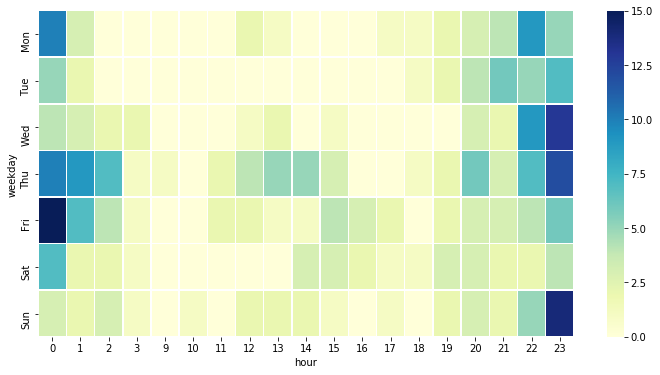

In [18]:
# 접속 시간대 분포 --> 게임이 30분~한 시간이니까 한 시간 단위로 끊으면 안될것같아
plt.figure(figsize=(12,6))
ax = sns.heatmap(matchTime, linewidths=.5, cmap="YlGnBu", yticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

In [ ]:
# 간단히 한 판 하는 시간대 vs 여러 판 하는 시간대